In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from comparablemodels.chiarellaIori import chilori_model
from comparablemodels.GHW2008 import ghwmodel
from stockmarket.stylizedfacts import *
import statsmodels.tsa.stattools as ts
%matplotlib inline

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Replicate comparable models

## 1 chiarella & Iori 2002

In [4]:
# set default parameters
number_of_agents = 1000
init_time = 1000
max_time = 50000
av_return_interval_min = 5
av_return_interval_max = 50 # previously Lmax
fundamental_value = 1000. # previously pf
allowed_price_steps = 0.1 # deltaP
variance_noise_forecast = 0.01 # prev sigmae
order_noise_max = 0.5 # prev kMax
order_expiration_time = 50 # prev tau
runType = 2
if runType == 0:
    fundamental_weight = 0.  # prev sigmaF
    momentum_weight = 0.    # prev sigmaM
    noise_weight = 1.       # prev sigmaN
if runType == 1:
    fundamental_weight = 1.
    momentum_weight = 0.
    noise_weight = 1.
if runType == 2:
    fundamental_weight = 1.
    momentum_weight = 10.
    noise_weight = 1.
ticks_per_day = 10

In [5]:
day_price, day_volume, day_return, price, returns, total_volume = chilori_model.ciarellilori2002(seed=1, max_time=max_time, 
                                                                                                 init_time=init_time, 
                                                                                                 number_of_agents=number_of_agents, 
                                                                                                 av_return_interval_min=av_return_interval_min,
                                                                                                 av_return_interval_max=av_return_interval_max, 
                                                                                                 fundamental_value=fundamental_value, 
                                                                                                 allowed_price_steps=allowed_price_steps, 
                                                                                                 variance_noise_forecast=variance_noise_forecast,
                                                                                                 order_noise_max=order_noise_max, 
                                                                                                 order_expiration_time=order_expiration_time, 
                                                                                                 fundamental_weight=fundamental_weight, 
                                                                                                 momentum_weight=momentum_weight, 
                                                                                                 noise_weight=noise_weight, 
                                                                                                 ticks_per_day=ticks_per_day)

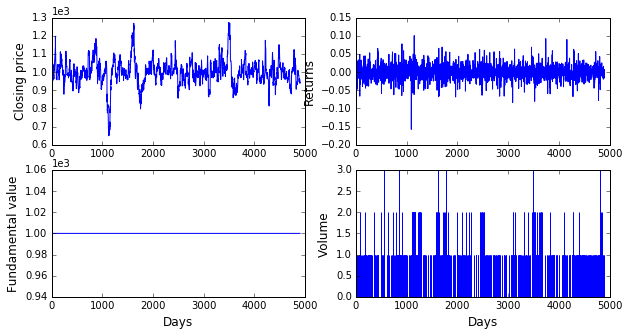

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))

ax1.plot(range(len(day_price)), day_price)
#ax1.set_ylim(0.02, 0.09)
ax1.set_ylabel('Closing price', fontsize='12')

ax2.plot(range(len(day_return)), day_return)
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(range(len(day_return)), [fundamental_value for x in range(len(day_return))])
#ax3.set_ylim(10, 33)
ax3.set_ylabel('Fundamental value', fontsize='12')
ax3.set_xlabel('Days', fontsize='12')

ax4.bar(range(len(day_volume)), day_volume, edgecolor='b')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Days', fontsize='12')

for ax in [ax1, ax2, ax3, ax4]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
#fig.savefig('chilori_dynamics.png')

## Mean reversion

In [12]:
relative_deviation_fund = (np.array(day_price) - np.array([fundamental_value for x in range(len(day_price))])) / np.array([fundamental_value for x in range(len(day_price))])

In [13]:
ts.adfuller(relative_deviation_fund, 1)

(-7.0936895506156166,
 4.3441654653452964e-10,
 1,
 4897,
 {'1%': -3.4316860692516502,
  '10%': -2.5670842686576476,
  '5%': -2.8621303954014028},
 -28298.075293442911)

In [24]:
pd.Series(day_return).autocorr()

-0.055607420212789055

In [25]:
autocorr_chilo_returns = [pd.Series(day_return).autocorr(lag=lag) for lag in range(25)]

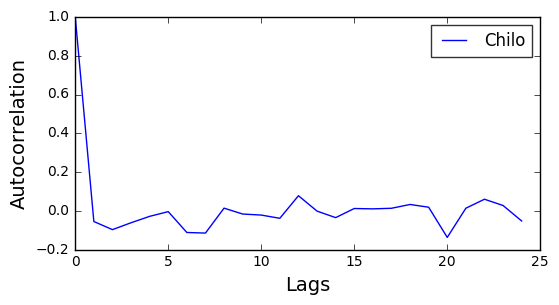

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

# ax1.plot(autocorr_returns.index, autocorr_returns.mean(axis=1), 'k-', label='Simulation')
# ax1.fill_between(autocorr_returns.index, 
#                  autocorr_returns.mean(axis=1)+autocorr_returns.std(axis=1), 
#                  autocorr_returns.mean(axis=1)-autocorr_returns.std(axis=1), 
#                  alpha=0.3, facecolor='black')


ax1.plot(range(len(autocorr_chilo_returns)), autocorr_chilo_returns, label='Chilo')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
#fig.savefig('auto_correlation.png')

## Kurtosis:

In [32]:
pd.Series(day_return).kurtosis()

1.5533925745493682

In [30]:
print('Fat tail in Chilo (kurtosis): ', fat_tails_kurtosis(day_return))

Fat tail in Chilo (kurtosis):  (False, inf)


# Clustered volatility

In [35]:
absolute_chilo_returns = pd.Series(day_return).abs()
autocorr_chilo_abs_returns = [absolute_chilo_returns.autocorr(lag=lag) for lag in range(25)]

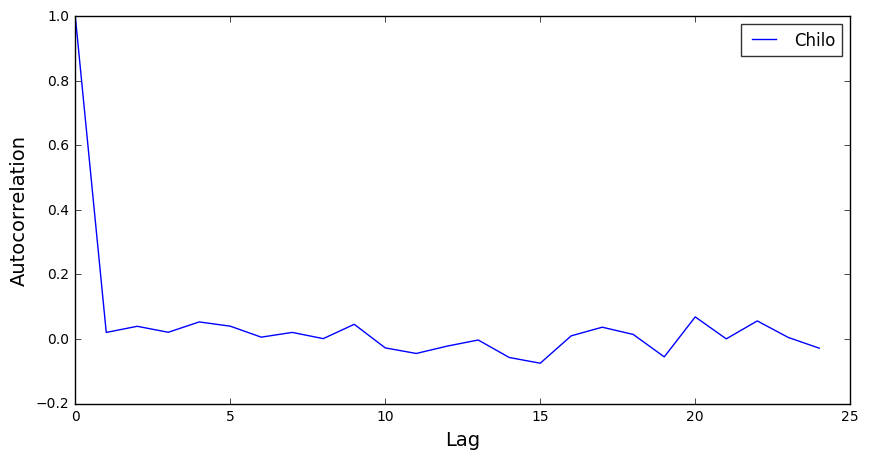

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

#ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns, label='Model')
ax1.plot(range(len(autocorr_chilo_abs_returns)), autocorr_chilo_abs_returns, label='Chilo')

# ax1.plot(autocorr_returns_abs.index, autocorr_returns_abs['seed_0'], 'k-', label='Benchmark simulation')
# ax1.fill_between(autocorr_returns_abs.index, 
#                  autocorr_returns_abs.mean(axis=1)+autocorr_returns_abs.std(axis=1), 
#                  autocorr_returns_abs.mean(axis=1)-autocorr_returns_abs.std(axis=1), 
#                  alpha=0.3, facecolor='black')


ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

## Long memory

In [38]:
print('Chilo long memory (hurst)', long_memory(pd.Series(day_return), hurst, 2, 20))

SP500 long memory (hurst) (True, -0.024423803899288478)


## Correlation between volume and volatility

In [39]:
window = 10

In [53]:
# volume
voll = pd.Series(day_volume)
# returns
roller_returns = pd.Series(returns).rolling(window)
returns_volatility = roller_returns.std(ddof=0)

In [54]:
print('Chilo cor vol volatility: ', returns_volatility.corr(voll))

Chilo cor vol volatility:  0.104320087728


## Gaunersdorfer, Hommes, and Wagener (2008). 

Bifurcation routes to volatility clustering under evolutionary learning. Journal of Economic Behavior and Organization, 67:27–47

In [3]:
price_deviation_from_fundamental, price, returns, fraction_type2 = ghwmodel.ghw_model(seed=1, simulation_time=10000, init_backward_simulated_time=4, chaos=0, risk_av_variance=1,
                       dividends=1, discount_rate=0.001, intensity_of_choice=2, fundamentalist_adaptive_parameter=1,
                       chartist_adaptive_parameter=1, bubble_sensitivity=1800, fitness_memory_strenght=0.99,
                       risk_adjustment=0, noise_std=10, init_price_dev_fundament=-400, init_type2_agents=0.5,
                       init_type2_holdings=0.5)

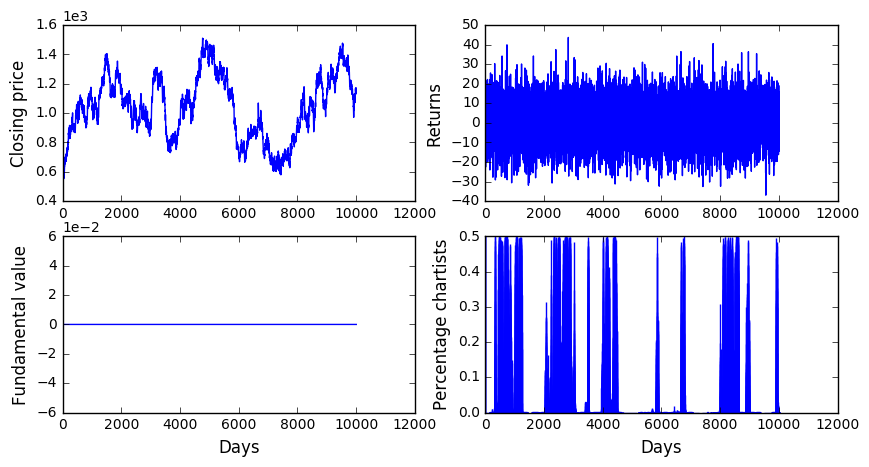

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))

ax1.plot(range(len(price)), price)
#ax1.set_ylim(0.02, 0.09)
ax1.set_ylabel('Closing price', fontsize='12')

ax2.plot(range(len(returns)), returns)
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(range(len(returns)), [0 for x in range(len(returns))])
#ax3.set_ylim(10, 33)
ax3.set_ylabel('Fundamental value', fontsize='12')
ax3.set_xlabel('Days', fontsize='12')

ax4.bar(range(len(fraction_type2)), fraction_type2, edgecolor='b')
ax4.set_ylabel('Percentage chartists', fontsize='12')
ax4.set_xlabel('Days', fontsize='12')

for ax in [ax1, ax2, ax3, ax4]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
#fig.savefig('chilori_dynamics.png')

## Autocorrelation

In [5]:
autocorr_ghw_returns = [pd.Series(returns).autocorr(lag=lag) for lag in range(25)]

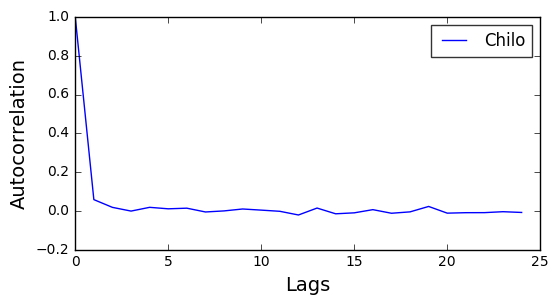

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(range(len(autocorr_ghw_returns)), autocorr_ghw_returns, label='Chilo')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
#fig.savefig('auto_correlation.png')

## Kurtosis

In [8]:
pd.Series(returns).kurtosis()

0.07979982668473129

In [9]:
print('Fat tail in GHW (kurtosis): ', fat_tails_kurtosis(returns))

Fat tail in GHW (kurtosis):  (False, inf)


## Clustered volatility

In [10]:
absolute_ghw_returns = pd.Series(returns).abs()
autocorr_ghw_abs_returns = [absolute_ghw_returns.autocorr(lag=lag) for lag in range(25)]

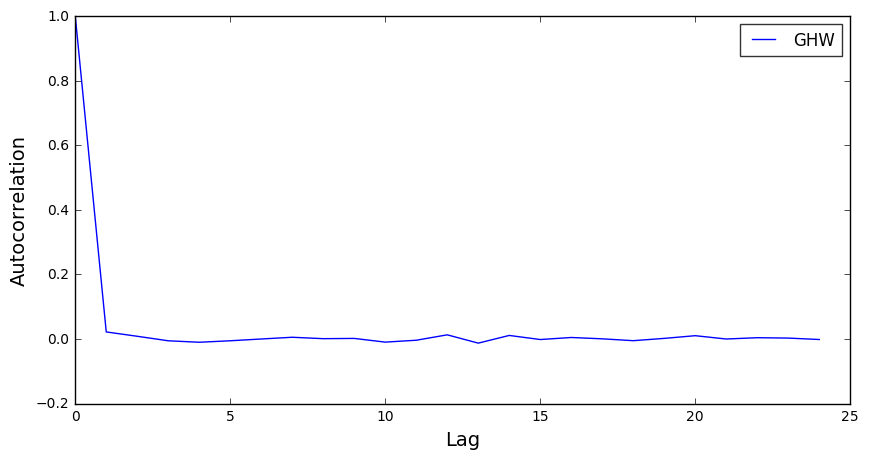

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

#ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns, label='Model')
ax1.plot(range(len(autocorr_ghw_abs_returns)), autocorr_ghw_abs_returns, label='GHW')

# ax1.plot(autocorr_returns_abs.index, autocorr_returns_abs['seed_0'], 'k-', label='Benchmark simulation')
# ax1.fill_between(autocorr_returns_abs.index, 
#                  autocorr_returns_abs.mean(axis=1)+autocorr_returns_abs.std(axis=1), 
#                  autocorr_returns_abs.mean(axis=1)-autocorr_returns_abs.std(axis=1), 
#                  alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

## Long memory

In [12]:
print('GHW long memory (hurst)', long_memory(pd.Series(returns), hurst, 2, 20))

GHW long memory (hurst) (True, 0.0037196380740816895)
